## 인공지능 수업 과제 1
### Kaggle : Predict future Sales Data 분석
* Linear regression에 알맞은 기본 데이터

### Linear regression 모델링

#### 해야할 것

1. 데이터 나누기 : overfitting이 일어날수 있기 떄문
    * Test data를 보관 : hold out method
        * Train data : Train, Validation , Test
        * Validation : Hyper parameter Tuning

2. 데이터 전처리
    * 탐색적 자료 분석(EDA)
    * Feature Engineering
        * 시계열 데이터 : 년 월 일
        * 가격 : binning?/ mean?
        * category : onehot 

3. 모델링
    * 아니 근데 리니어 레그레이션을 쓸거면 연속적인 값을 사용해야되나?
    * 적합한 모델 선정 : Linear regression
    * 모델에 적합한 하이퍼 파라미터 선정
    * 다양한 전처리 경우의 수 입력
    * 학습 실행
    * 성능 평가
        * R squared
        * RMSE

## code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
import datetime

In [2]:
# load data
df_train = pd.read_csv("predict_future_sales_data/sales_train.csv")
df_items = pd.read_csv("predict_future_sales_data/items.csv") 
df_shops = pd.read_csv("predict_future_sales_data/shops.csv")
df_sample = pd.read_csv("predict_future_sales_data/sample_submission.csv")
df_test = pd.read_csv("predict_future_sales_data/test.csv")
df_category = pd.read_csv("predict_future_sales_data/item_categories.csv")

#### google translator : translator.translate(x, dest='en').text

In [3]:
# google translate
# categoty, shops에 러시아어를 영어로 번역 
from googletrans import Translator
translator = Translator()
df_category['item_category_name'] = df_category['item_category_name'].apply(lambda x : translator.translate(x, dest='en').text)
df_shops['shop_name'] = df_shops['shop_name'].apply(lambda x : translator.translate(x, dest='en').text)

### 1. EDA

#### missing data : 없음 

In [4]:
# check missing value 없음 
print(np.sum(pd.isnull(df_train)))
print(np.sum(pd.isnull(df_items)))
print(np.sum(pd.isnull(df_category)))
print(np.sum(pd.isnull(df_shops)))

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
item_name           0
item_id             0
item_category_id    0
dtype: int64
item_category_name    0
item_category_id      0
dtype: int64
shop_name    0
shop_id      0
dtype: int64


In [5]:
# item 이름 까지는 굳이 필요하지 않을것이라고 생각
del df_items['item_name']

#### category, item 병합 , 대분류 나눠주기 

In [6]:
# item, categry dataframe 병합 , item_category_id
# category 대분류 분리
df_item_category = pd.merge(df_items, df_category, on="item_category_id", how = "left")
df_item_category["big_category"] = df_item_category['item_category_name'].apply(lambda name : name.split(' - ')[0])
del df_item_category['item_category_name']
df_item_category.head()

,item_id,item_category_id,big_category
0,0,40,Movie
1,1,76,Programs
2,2,40,Movie
3,3,40,Movie
4,4,40,Movie


### category 더 줄이기

In [7]:
df_item_category.big_category.unique()
game_list = ['Игры','Games','PC Games','MAC Games','Android Games']
card_list = ['Payment cards (Cinema, Music, Games)','Payment Cards','Payment cards', 'Gifts', 'Tickets (Number)']
movie_list = ['Movie','Cinema']
service_list = ['Service','Delivery of goods',]
acc_list = ['Books','Accessories','Game consoles', 'Batteries','Programs','Game Consoles']
bm_list = ['Blank media (piece)', 'Blank media (spire)']

In [8]:
df_big = pd.DataFrame(df_item_category['big_category'])
df_big['big_category'].unique()

array(['Movie', 'Programs', 'Music', 'Games', 'PC Games', 'Cinema',
       'Books', 'Gifts', 'Игры', 'Payment cards (Cinema, Music, Games)',
       'Accessories', 'MAC Games', 'Android Games', 'Game consoles', 'PC',
       'Payment cards', 'Tickets (Number)', 'Service',
       'Delivery of goods', 'Game Consoles', 'Payment Cards',
       'Blank media (piece)', 'Blank media (spire)', 'Batteries'],
      dtype=object)

In [9]:
def change_cate(df,cate_list,name : str()):
    for i in range(len(cate_list)) : 
        df[df['big_category'] == cate_list[i]] = name


In [10]:
change_cate(df_big, game_list,'Games')
change_cate(df_big, card_list,'Card')
change_cate(df_big, movie_list,'Movie')
change_cate(df_big, service_list,'Service')
change_cate(df_big, acc_list,'Accessory')
change_cate(df_big, bm_list, 'Blank_media')
df_item_category['big_category'] = df_big

In [11]:
df_item_category

,item_id,item_category_id,big_category
0,0,40,Movie
1,1,76,Accessory
2,2,40,Movie
3,3,40,Movie
4,4,40,Movie
...,...,...,...
22165,22165,31,Games
22166,22166,54,Accessory
22167,22167,49,Accessory
22168,22168,62,Card


#### 한 매장에서도 매월 가격이 변하는 것을 알 수 있다.

In [12]:
df_item_category[df_item_category['item_id']==5037]

,item_id,item_category_id,big_category
5037,5037,19,Games


Text(0.5, 1.0, 'PS3 판매량 변화')

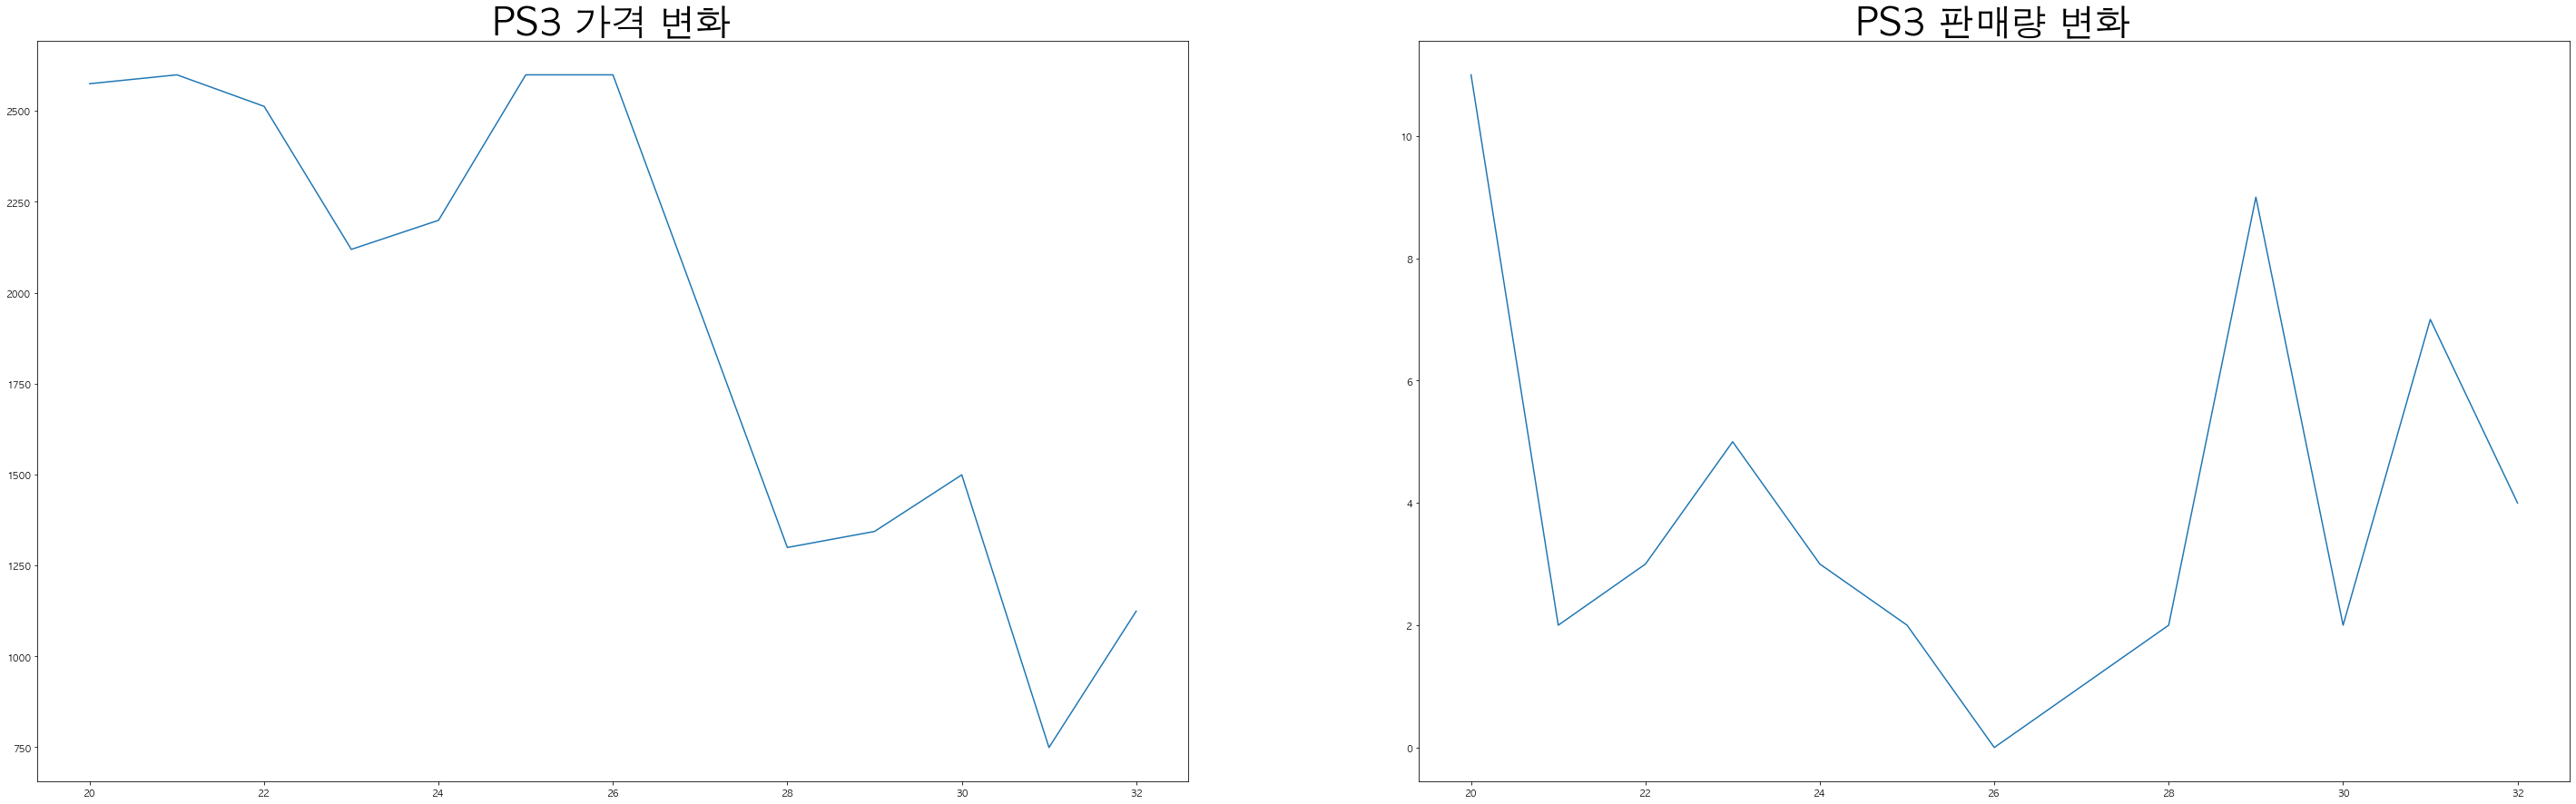

In [13]:
df_item_price = df_train.loc[ :, ['shop_id','date_block_num','item_id','item_price','item_cnt_day']]
df_5037 = df_item_price[df_item_price['item_id'] == 5037]

# 가격이 변하는 경우가 있다? #31번 shop에서 5037(ps3)제품 59개를 팜 
fig, ax = plt.subplots(1, 2,figsize=(50,15))
ax[0].plot(df_5037[df_5037['shop_id'] == 59].groupby('date_block_num')['item_price'].mean())
ax[0].set_title("PS3 가격 변화",fontsize =40)
# 가격이 쌀 때 판매량이 오르는 모습이 보임
ax[1].plot(df_5037[df_5037['shop_id'] == 59].groupby('date_block_num')['item_cnt_day'].sum())
ax[1].set_title("PS3 판매량 변화",fontsize =40)

#### 판매량과 가격 사이의 음의 상관관계가 존재

In [14]:
# 판매량과 가격 사이에 음의 상관관계 존재 
ex = pd.DataFrame()
ex['count'] = df_5037[df_5037['shop_id'] == 59].groupby('date_block_num')['item_cnt_day'].sum()
ex['price'] = df_5037[df_5037['shop_id'] == 59].groupby('date_block_num')['item_price'].mean()       
ex.corr()

,count,price
count,1.000000,-0.237562
price,-0.237562,1.000000


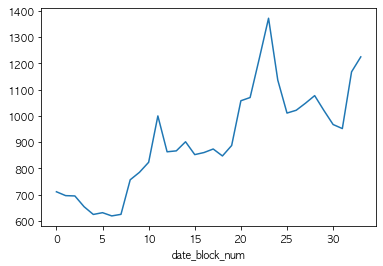

In [15]:
df_item_price.groupby('date_block_num')['item_price'].mean().plot()

In [16]:
# item별 가격 mean()
df_item_price = df_train.loc[ :, ['shop_id','date_block_num','item_id','item_price','item_cnt_day']]
price = pd.DataFrame(df_item_price.groupby('item_id')['item_price'].mean())

In [17]:
# 이상치 제거 IQR
Q1 = np.percentile(price,25)
Q3 = np.percentile(price,75)
IQR = Q3 - Q1
outlier_min = Q1 - 1.5*IQR
outlier_max = Q3 + 1.5*IQR
price[price.item_price > outlier_max ] = outlier_max 
price = price.reset_index()
# scailing
scale = price['item_price'].max() - price['item_price'].min()
price['scailing_price'] = price['item_price'] / scale

In [19]:
del price['item_price']

In [20]:
price

,item_id,scailing_price
0,0,0.031517
1,1,1.002671
2,2,0.031517
3,3,0.042928
4,4,0.031517
...,...,...
21802,22165,0.032060
21803,22166,0.081510
21804,22167,0.161762
21805,22168,0.434129


### shop을 어떻게 나눌까 ?


In [164]:
shops = df_train.copy()

In [165]:
shops

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [174]:
# shop별 판매량 
sales = pd.DataFrame(shops.groupby('shop_id')['item_cnt_day'].sum())

In [175]:
# 이상치 제거 IQR
Q1 = np.percentile(sales,25)
Q3 = np.percentile(sales,75)
IQR = Q3 - Q1
outlier_min = Q1 - 1.5*IQR
outlier_max = Q3 + 1.5*IQR
sales[sales.item_cnt_day > outlier_max ] = outlier_max
sales[sales.item_cnt_day < outlier_min ] = outlier_min
sales = sales.reset_index()
# scailing
scale = sales['item_cnt_day'].max() - sales['item_cnt_day'].min()
sales['scailing_sales'] = sales['item_cnt_day'] / scale
del sales['item_cnt_day']
sales

,shop_id,item_cnt_day,scailing_sales
0,0,11705.000,0.084466
1,1,6311.000,0.045542
2,2,30620.000,0.220962
3,3,28355.000,0.204617
4,4,43942.000,0.317096
5,5,42762.000,0.308581
6,6,100489.000,0.725154
7,7,67058.000,0.483907
8,8,3595.000,0.025942
9,9,15866.000,0.114493


In [177]:
sales

,shop_id,scailing_sales
0,0,0.084466
1,1,0.045542
2,2,0.220962
3,3,0.204617
4,4,0.317096
5,5,0.308581
6,6,0.725154
7,7,0.483907
8,8,0.025942
9,9,0.114493


### 2. data preprocessing

#### train data, item_category 병합

In [21]:
# df_all = pd.merge(df_train,df_item_category, on = "item_id", how = "left")
# del df_all['date']
df_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [269]:
from datetime import datetime
df_train['year'] = pd.to_datetime(df_train['date']).dt.strftime('%Y')

In [268]:
df_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
0,02.01.2013,0,59,22154,999.00,1.0,2013,02
1,03.01.2013,0,25,2552,899.00,1.0,2013,03
2,05.01.2013,0,25,2552,899.00,-1.0,2013,05
3,06.01.2013,0,25,2554,1709.05,1.0,2013,06
4,15.01.2013,0,25,2555,1099.00,1.0,2013,01
...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,2015,10
2935845,09.10.2015,33,25,7460,299.00,1.0,2015,09
2935846,14.10.2015,33,25,7459,349.00,1.0,2015,10
2935847,22.10.2015,33,25,7440,299.00,1.0,2015,10


#### train에 test에 없는 shop, item들이 존재 : test에 해당하는 것만 사용 / item_cnt_month 생성

In [22]:
x_train = df_train[df_train.shop_id.isin(df_test.shop_id.unique())]
x_train = x_train[x_train.item_id.isin(df_test.item_id.unique())]
x_train['date'] = x_train['date'].apply(lambda x : int(x[3:5]))
x_train = pd.DataFrame(x_train.groupby(['date_block_num','date','shop_id','item_id'],as_index=False)['item_cnt_day'].sum())
x_train.rename(columns={'item_cnt_day' : 'item_cnt_month', 'date' : 'month'}, inplace = True )
x_train

,date_block_num,month,shop_id,item_id,item_cnt_month
0,0,1,2,33,1.0
1,0,1,2,482,1.0
2,0,1,2,491,1.0
3,0,1,2,839,1.0
4,0,1,2,1007,3.0
...,...,...,...,...,...
600154,33,10,59,22087,6.0
600155,33,10,59,22088,2.0
600156,33,10,59,22091,1.0
600157,33,10,59,22100,1.0


### shop_id 처리
### 샵개수

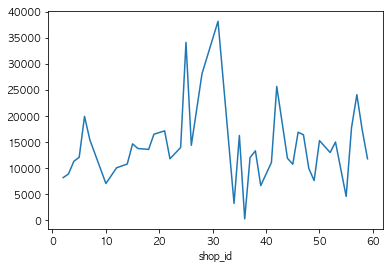

In [45]:
x_train.groupby('shop_id')['item_id'].count().plot()

#### test data 처리

In [23]:
# 다음달 데이터를 예측하는 것이므로 date_block_num = 34
df_test["date_block_num"] = 34
df_test['month'] = 11
# df_test['item_price'] = 0 
# x_test = pd.merge(df_test,df_item_category, on = 'item_id', how = 'left')
df_test

,ID,shop_id,item_id,date_block_num,month
0,0,5,5037,34,11
1,1,5,5320,34,11
2,2,5,5233,34,11
3,3,5,5232,34,11
4,4,5,5268,34,11
...,...,...,...,...,...
214195,214195,45,18454,34,11
214196,214196,45,16188,34,11
214197,214197,45,15757,34,11
214198,214198,45,19648,34,11


In [24]:
# train test 합쳐주기 
df_train_test = pd.concat([x_train, df_test], axis = 0)
df_train_test

,date_block_num,month,shop_id,item_id,item_cnt_month,ID
0,0,1,2,33,1.0,NaN
1,0,1,2,482,1.0,NaN
2,0,1,2,491,1.0,NaN
3,0,1,2,839,1.0,NaN
4,0,1,2,1007,3.0,NaN
...,...,...,...,...,...,...
214195,34,11,45,18454,NaN,214195.0
214196,34,11,45,16188,NaN,214196.0
214197,34,11,45,15757,NaN,214197.0
214198,34,11,45,19648,NaN,214198.0


In [25]:
# item_category 합치기 
df_all = pd.merge(df_train_test,df_item_category, on = "item_id", how = "left")

,date_block_num,month,shop_id,item_id,item_cnt_month,ID,item_category_id,big_category
0,0,1,2,33,1.0,NaN,37,Movie
1,0,1,2,482,1.0,NaN,73,Accessory
2,0,1,2,491,1.0,NaN,73,Accessory
3,0,1,2,839,1.0,NaN,73,Accessory
4,0,1,2,1007,3.0,NaN,67,Card
...,...,...,...,...,...,...,...,...
814354,34,11,45,18454,NaN,214195.0,55,Music
814355,34,11,45,16188,NaN,214196.0,64,Card
814356,34,11,45,15757,NaN,214197.0,55,Music
814357,34,11,45,19648,NaN,214198.0,40,Movie


In [26]:
# price 넣기
df_all = pd.merge(df_all,price, on ='item_id', how = 'left')

,date_block_num,month,shop_id,item_id,item_cnt_month,ID,item_category_id,big_category,scailing_price
0,0,1,2,33,1.0,NaN,37,Movie,0.137388
1,0,1,2,482,1.0,NaN,73,Accessory,1.002671
2,0,1,2,491,1.0,NaN,73,Accessory,0.321290
3,0,1,2,839,1.0,NaN,73,Accessory,1.002671
4,0,1,2,1007,3.0,NaN,67,Card,0.316013
...,...,...,...,...,...,...,...,...,...
814354,34,11,45,18454,NaN,214195.0,55,Music,0.102529
814355,34,11,45,16188,NaN,214196.0,64,Card,0.683037
814356,34,11,45,15757,NaN,214197.0,55,Music,0.107654
814357,34,11,45,19648,NaN,214198.0,40,Movie,0.053305


In [250]:
# get dummy
df_train_test = pd.get_dummies(df_all, columns = ['big_category'])
df_train_test

,date_block_num,month,shop_id,item_id,item_cnt_month,ID,item_category_id,scailing_price,big_category_Accessory,big_category_Card,big_category_Games,big_category_Movie,big_category_Music,big_category_PC,big_category_Service
0,0,1,2,33,1.0,NaN,37,0.137388,0,0,0,1,0,0,0
1,0,1,2,482,1.0,NaN,73,1.002671,1,0,0,0,0,0,0
2,0,1,2,491,1.0,NaN,73,0.321290,1,0,0,0,0,0,0
3,0,1,2,839,1.0,NaN,73,1.002671,1,0,0,0,0,0,0
4,0,1,2,1007,3.0,NaN,67,0.316013,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814354,34,11,45,18454,NaN,214195.0,55,0.102529,0,0,0,0,1,0,0
814355,34,11,45,16188,NaN,214196.0,64,0.683037,0,1,0,0,0,0,0
814356,34,11,45,15757,NaN,214197.0,55,0.107654,0,0,0,0,1,0,0
814357,34,11,45,19648,NaN,214198.0,40,0.053305,0,0,0,1,0,0,0


In [251]:
df_train_test = pd.merge(df_train_test,sales, on = 'shop_id', how = 'left')
del df_train_test['ID']
df_train_test

,date_block_num,month,shop_id,item_id,item_cnt_month,item_category_id,scailing_price,big_category_Accessory,big_category_Card,big_category_Games,big_category_Movie,big_category_Music,big_category_PC,big_category_Service,scailing_sales
0,0,1,2,33,1.0,37,0.137388,0,0,0,1,0,0,0,0.220962
1,0,1,2,482,1.0,73,1.002671,1,0,0,0,0,0,0,0.220962
2,0,1,2,491,1.0,73,0.321290,1,0,0,0,0,0,0,0.220962
3,0,1,2,839,1.0,73,1.002671,1,0,0,0,0,0,0,0.220962
4,0,1,2,1007,3.0,67,0.316013,0,1,0,0,0,0,0,0.220962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814354,34,11,45,18454,NaN,55,0.102529,0,0,0,0,1,0,0,0.302325
814355,34,11,45,16188,NaN,64,0.683037,0,1,0,0,0,0,0,0.302325
814356,34,11,45,15757,NaN,55,0.107654,0,0,0,0,1,0,0,0.302325
814357,34,11,45,19648,NaN,40,0.053305,0,0,0,1,0,0,0,0.302325


In [252]:
# train,test split
new_test = df_train_test[df_train_test['date_block_num'] == 34].copy()
new_train = df_train_test[df_train_test['date_block_num'] < 34].copy()

### validation

In [254]:
new_val = new_train[new_train['date_block_num'] == 32 ]
new_train = new_train[new_train['date_block_num'] != 33]


In [255]:
new_train_y = new_train['item_cnt_month'].copy()
del new_train['item_cnt_month']

In [256]:
new_val_y = new_val['item_cnt_month'].copy()
del new_val['item_cnt_month']

In [257]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept = True)
model = model.fit(new_train,new_train_y)
y_val_pred = model.predict(new_val)

In [90]:
# item_id포함
from sklearn.metrics import median_absolute_error, mean_squared_error, r2_score

print("MAE : ",median_absolute_error(new_val_y,y_val_pred))
print("RMSE : ",mean_squared_error(new_val_y,y_val_pred)**0.5)
print("R2 score", r2_score(new_val_y,y_val_pred))

MAE :  1.1721894387069867
RMSE :  11.698876630404774
R2 score 0.019952280617489104


In [203]:
# scailing shop
print("MAE : ",median_absolute_error(new_val_y,y_val_pred))
print("RMSE : ",mean_squared_error(new_val_y,y_val_pred)**0.5)
print("R2 score", r2_score(new_val_y,y_val_pred))

MAE :  1.2575829544823343
RMSE :  11.690923035028579
R2 score 0.021284417631168173


In [258]:
# 3
print("MAE : ",median_absolute_error(new_val_y,y_val_pred))
print("RMSE : ",mean_squared_error(new_val_y,y_val_pred)**0.5)
print("R2 score", r2_score(new_val_y,y_val_pred))

MAE :  1.2565811626815733
RMSE :  6.683738089002187
R2 score 0.032642630062237776


In [204]:
new_test

,date_block_num,month,item_id,item_cnt_month,ID,item_category_id,scailing_price,big_category_Accessory,big_category_Card,big_category_Games,big_category_Movie,big_category_Music,big_category_PC,big_category_Service,scailing_sales
600159,34,11,5037,NaN,0.0,19,1.002671,0,0,1,0,0,0,0,0.308581
600160,34,11,5320,NaN,1.0,55,NaN,0,0,0,0,1,0,0,0.308581
600161,34,11,5233,NaN,2.0,19,0.435141,0,0,1,0,0,0,0,0.308581
600162,34,11,5232,NaN,3.0,23,0.429563,0,0,1,0,0,0,0,0.308581
600163,34,11,5268,NaN,4.0,20,NaN,0,0,1,0,0,0,0,0.308581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814354,34,11,18454,NaN,214195.0,55,0.102529,0,0,0,0,1,0,0,0.302325
814355,34,11,16188,NaN,214196.0,64,0.683037,0,1,0,0,0,0,0,0.302325
814356,34,11,15757,NaN,214197.0,55,0.107654,0,0,0,0,1,0,0,0.302325
814357,34,11,19648,NaN,214198.0,40,0.053305,0,0,0,1,0,0,0,0.302325


### prediction

In [259]:
del new_test['item_cnt_month']
# scailing_price가 training에 없는 경우 
new_test['scailing_price'] = new_test['scailing_price'].fillna(0)
new_test

,date_block_num,month,shop_id,item_id,item_category_id,scailing_price,big_category_Accessory,big_category_Card,big_category_Games,big_category_Movie,big_category_Music,big_category_PC,big_category_Service,scailing_sales
600159,34,11,5,5037,19,1.002671,0,0,1,0,0,0,0,0.308581
600160,34,11,5,5320,55,0.000000,0,0,0,0,1,0,0,0.308581
600161,34,11,5,5233,19,0.435141,0,0,1,0,0,0,0,0.308581
600162,34,11,5,5232,23,0.429563,0,0,1,0,0,0,0,0.308581
600163,34,11,5,5268,20,0.000000,0,0,1,0,0,0,0,0.308581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814354,34,11,45,18454,55,0.102529,0,0,0,0,1,0,0,0.302325
814355,34,11,45,16188,64,0.683037,0,1,0,0,0,0,0,0.302325
814356,34,11,45,15757,55,0.107654,0,0,0,0,1,0,0,0.302325
814357,34,11,45,19648,40,0.053305,0,0,0,1,0,0,0,0.302325


In [260]:
new_test.isnull().sum()

date_block_num            0
month                     0
shop_id                   0
item_id                   0
item_category_id          0
scailing_price            0
big_category_Accessory    0
big_category_Card         0
big_category_Games        0
big_category_Movie        0
big_category_Music        0
big_category_PC           0
big_category_Service      0
scailing_sales            0
dtype: int64

In [261]:
# testset
model = LinearRegression(fit_intercept = True)
model = model.fit(new_train,new_train_y)
y_new = model.predict(new_test)

In [262]:
y_new

array([2.35941956, 0.51928251, 2.97179066, ..., 0.60202771, 1.15713678,
       0.25993313])

In [263]:
submission = pd.DataFrame(y_new).reset_index()
submission

,index,0
0,0,2.359420
1,1,0.519283
2,2,2.971791
3,3,2.923527
4,4,3.423426
...,...,...
214195,214195,0.709096
214196,214196,2.620266
214197,214197,0.602028
214198,214198,1.157137


In [264]:
submission.rename(columns={'index' : 'ID', 0 : 'item_cnt_month'}, inplace = True )

In [244]:
submission

,ID,item_cnt_month
0,0,2.219467
1,1,0.550751
2,2,2.793991
3,3,2.799637
4,4,3.234497
...,...,...
214195,214195,0.432144
214196,214196,2.645157
214197,214197,0.426956
214198,214198,1.030121


In [245]:
submission.to_csv('submission.csv', index = False)

In [105]:
submission

,ID,item_cnt_month
0,0,2.768490
1,1,1.111614
2,2,3.392656
3,3,3.351053
4,4,3.854564
...,...,...
214195,214195,1.507746
214196,214196,3.388097
214197,214197,1.390996
214198,214198,1.943827


In [106]:
df_sample

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5
